In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d

from scipy.optimize import curve_fit
from PIL import Image

from scipy.special import softmax
import imageio
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [102]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run):
    
    #emb without void node
    
    x=x[1:]
    y=y[1:]
    t=t[1:]
    #############
    
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            #A[i,0]=1.5
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt('./'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):

def fit_func(x,a,b):
    return a*x+b

def fingerprint_emb(pos_x,pos_y,window,path,void_node=True,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747):
    x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
    im = Image.open(path).convert('L') # Can be many different formats.
    im_crop = im.crop((x_l, y_l, x_r, y_u))
    foo = im_crop.resize((10,10),Image.ANTIALIAS)
    imarray = np.asarray(foo)
    imarray=imarray.flatten()/255
    return imarray



def fingerprint_wrap(window,run,void=False):
    pos_x,pos_y,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',usecols=(0,1,6), unpack=True)
    l=len(pos_x)-1
    
    
    f_e = np.array([np.zeros(100)])


    for k in range(int(np.max(t))+1):
        path='/home/mo/Desktop/IWR/TimeGraph/'+str(run)+'/'+str(k)+'.png'
        pos_x_n=pos_x[t==k]
        pos_y_n=pos_y[t==k]
        if k==0:
            pos_x_n=pos_x_n[1:]
            pos_y_n=pos_y_n[1:]
        for j in range(len(pos_x_n)):
            imarray=np.array([fingerprint_emb(pos_x_n[j],pos_y_n[j],window,path)])
            f_e=np.concatenate((f_e, imarray), axis=0)
            
    
    if void==False:
        f_e=f_e[1:]
            
        
    return f_e
    
    
'''
pos_x=[5.926355409057428858e-01,4.604170197372819962e-01,6.250962551422760416e-02,1.223613241454796496e-01,6.376507269405902179e-01,1.103583087228645621e-01,4.233227679149828004e-01]
pos_y=[5.378065857159227692e-01,5.482527480620434934e-01,1.628245440499290486e-01,8.255699686855265673e-01,5.184511465256566032e-01,1.492480151352687523e-01,5.115442664966730613e-01]
pix_x=[87,72,27,33,92,32,68]
pix_y=[70,69,113,37,72,114,73]


plt.errorbar(pos_y, pix_y,fmt='.')   

popt, pcov = curve_fit(fit_func, pos_y,pix_y)

plt.plot(pos_y, fit_func(np.array(pos_y),*popt))
print(popt)
'''

a_y=-114.14194117
a_x=113.89266922
b_y=131.3404747
b_x=19.51478307
    
def calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window):
    pix_x0=int(fit_func(pos_x,a_x,b_x))
    
    pix_y0=int(fit_func(pos_y,a_y,b_y))
    #print(pix_x0,pix_y0,int(pix_x0-window))
    return int(pix_x0-window),int(pix_x0+window),int(pix_y0-window),int(pix_y0+window)


In [105]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)

print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))


A,B,E =padding(7,1)

print(E)

1.2720668358645384


IndexError: index 233 is out of bounds for axis 0 with size 233

In [106]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
    make_dist_matrix(x,y,t,run)
    
maxlen=np.max(lenA)
print(maxlen)






234 1
213 2
221 3
214 4
231 5
252 6
227 7
224 8
250 9
242 10
266 11
223 12
236 13
239 14
266


In [101]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    f_e=fingerprint_wrap(20,run,void=False)
    
    #pos_x,pos_y= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',, unpack=True)
    #id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b),run)
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    #padding(maxlen,run)
    

245 1
260 2
200 3
253 4
212 5
201 6
200 7
237 8
213 9
217 10
202 11
172 12
215 13
202 14


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

In [ ]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

<IPython.core.display.Javascript object>


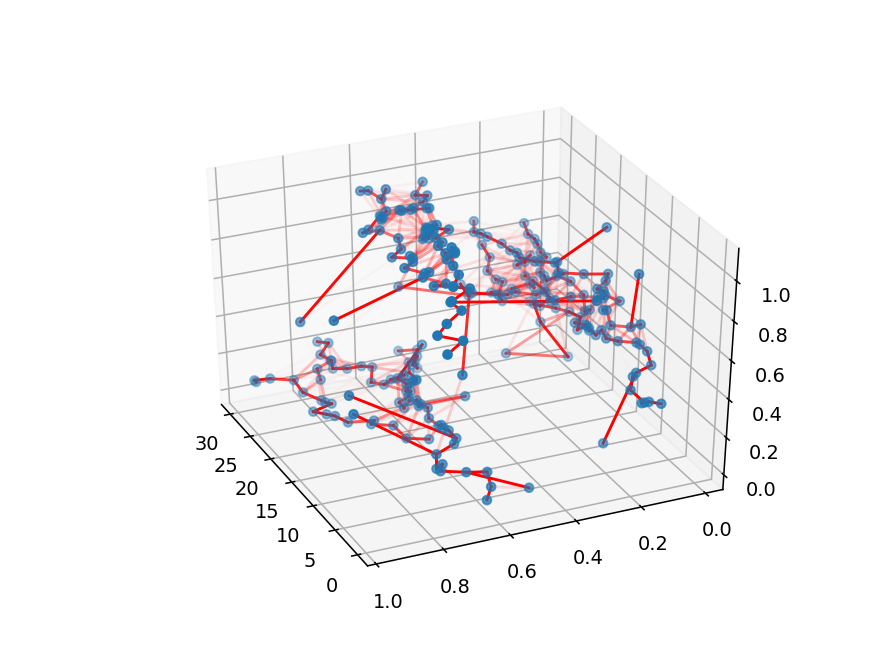

1.0 5.0
[0.8544088176352705, 0.8789932662714333]
2.0 6.0
[0.06623246492985972, 0.10130949310250842]
3.0 4.0
[0.3854709418837675, 0.3788081199799602]
4.0 10.0
[0.3788081199799602, 0.3494603553045518]
5.0 8.0
[0.8789932662714333, 0.9010901910875673]
6.0 7.0
[0.10130949310250842, 0.1538038358901365]
6.0 9.0
[0.10130949310250842, 0.022044088176352703]
7.0 12.0
[0.1538038358901365, 0.14486496758167527]
8.0 13.0
[0.9010901910875673, 0.9223557774572475]
9.0 12.0
[0.022044088176352703, 0.14486496758167527]
10.0 11.0
[0.3494603553045518, 0.32010177979879395]
11.0 16.0
[0.32010177979879395, 0.3718061989101556]
12.0 15.0
[0.14486496758167527, 0.147930484444417]
13.0 14.0
[0.9223557774572475, 0.9468713077336677]
14.0 18.0
[0.9468713077336677, 0.9710905853724511]
15.0 19.0
[0.147930484444417, 0.15218120906178864]
16.0 20.0
[0.3718061989101556, 0.41019823440530756]
17.0 18.0
[0.8657314629258517, 0.9710905853724511]
17.0 20.0
[0.8657314629258517, 0.41019823440530756]
18.0 26.0
[0.9710905853724511, 0.

[0.07249782568063373, 0.07249782568063373]
122.0 131.0
[0.49987480302647225, 0.46630102683196406]
122.0 132.0
[0.49987480302647225, 0.643343626332421]
122.0 135.0
[0.49987480302647225, 0.5456196408420471]
122.0 142.0
[0.49987480302647225, 0.34086369101658]
123.0 134.0
[0.9499124866258218, 0.9109887998569646]
123.0 137.0
[0.9499124866258218, 0.8925836000729572]
123.0 141.0
[0.9499124866258218, 1.0160594417189428]
124.0 131.0
[0.664342689919832, 0.46630102683196406]
124.0 132.0
[0.664342689919832, 0.643343626332421]
124.0 135.0
[0.664342689919832, 0.5456196408420471]
125.0 131.0
[0.3279000601721952, 0.46630102683196406]
125.0 135.0
[0.3279000601721952, 0.5456196408420471]
125.0 142.0
[0.3279000601721952, 0.34086369101658]
126.0 133.0
[0.08188082793623885, 0.07664645250992744]
126.0 138.0
[0.08188082793623885, 0.17341965958748398]
127.0 131.0
[0.21042084168336672, 0.46630102683196406]
127.0 133.0
[0.21042084168336672, 0.07664645250992744]
127.0 136.0
[0.21042084168336672, 0.09619238476953

176.0 200.0
[0.5802581751868782, 0.5230460921843687]
176.0 201.0
[0.5802581751868782, 0.44394382866176085]
177.0 190.0
[0.9228180114006103, 1.025807088008691]
177.0 191.0
[0.9228180114006103, 0.9156272966805546]
177.0 196.0
[0.9228180114006103, 0.9289661500123355]
178.0 194.0
[0.12408823155565062, 0.12068517312527163]
178.0 195.0
[0.12408823155565062, 0.1261484397840348]
179.0 189.0
[0.4614120936088759, 0.601047832871401]
179.0 193.0
[0.4614120936088759, 0.3508128136456662]
179.0 198.0
[0.4614120936088759, 0.45544002052899923]
179.0 199.0
[0.4614120936088759, 0.37289809567132404]
179.0 200.0
[0.4614120936088759, 0.5230460921843687]
179.0 201.0
[0.4614120936088759, 0.44394382866176085]
180.0 192.0
[0.0735685100169438, 0.12164939054720345]
180.0 195.0
[0.0735685100169438, 0.1261484397840348]
180.0 202.0
[0.0735685100169438, 0.18900306515548743]
181.0 189.0
[0.4749664801285779, 0.601047832871401]
181.0 193.0
[0.4749664801285779, 0.3508128136456662]
181.0 198.0
[0.4749664801285779, 0.45544

In [107]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=6

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)

x=x[1:]
y=y[1:]
t=t[1:]

#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

#plt.savefig('./TimeGraph.png',dpi=my_dpi,transparent=False) 

blue


<IPython.core.display.Javascript object>


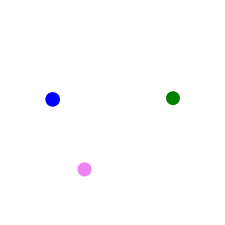

c_full ['blue', 'green', 'violet']
ii 2.0
['blue', 'green', 'violet']
ii 3.0
['blue', 'green', 'violet']
ii 4.0
['blue', 'green', 'violet']


<IPython.core.display.Javascript object>


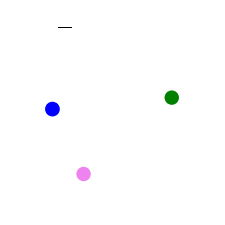

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'green' 'violet']
c ['blue']


<IPython.core.display.Javascript object>


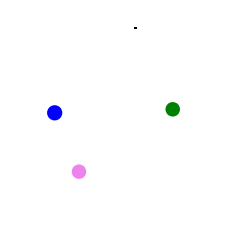

c_full ['violet', 'green', 'black', 'blue']
prev_c ['violet' 'green' 'black' 'blue']
c ['blue']
prev_c ['violet' 'green' 'black' 'blue']
c ['violet']
prev_c ['violet' 'green' 'black' 'blue']
c ['green']


<IPython.core.display.Javascript object>


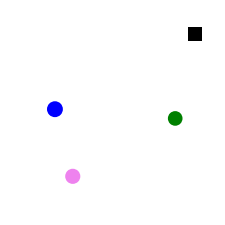

c_full ['black', 'blue', 'violet', 'green']
prev_c ['black' 'blue' 'violet' 'green']
c ['green']
prev_c ['black' 'blue' 'violet' 'green']
c ['violet']
prev_c ['black' 'blue' 'violet' 'green']
c ['blue']


<IPython.core.display.Javascript object>


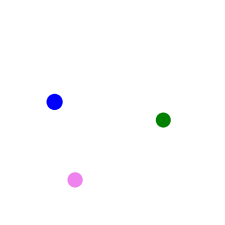

c_full ['green', 'violet', 'blue', 'black']
prev_c ['green' 'violet' 'blue' 'black']
c ['violet']
prev_c ['green' 'violet' 'blue' 'black']
c ['blue']
prev_c ['green' 'violet' 'blue' 'black']
c ['green']


<IPython.core.display.Javascript object>


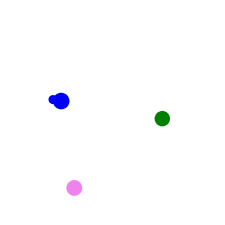

c_full ['violet', 'blue', 'green']
prev_c ['violet' 'blue' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green']
c ['green']
prev_c ['violet' 'blue' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green']
c ['violet']


<IPython.core.display.Javascript object>


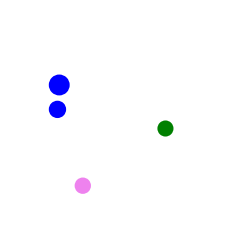

c_full ['blue', 'green', 'blue', 'violet']
prev_c ['blue' 'green' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'green' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'green' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'green' 'blue' 'violet']
c ['green']


<IPython.core.display.Javascript object>


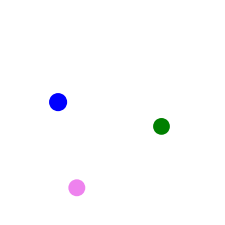

c_full ['blue', 'violet', 'blue', 'green']
prev_c ['blue' 'violet' 'blue' 'green']
c ['green']
prev_c ['blue' 'violet' 'blue' 'green']
c ['violet']
prev_c ['blue' 'violet' 'blue' 'green']
c ['blue']


<IPython.core.display.Javascript object>


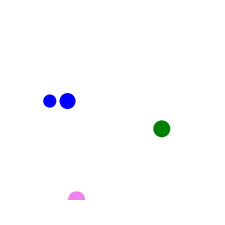

c_full ['green', 'violet', 'blue']
prev_c ['green' 'violet' 'blue']
c ['blue']
prev_c ['green' 'violet' 'blue']
c ['violet']
prev_c ['green' 'violet' 'blue']
c ['blue']
prev_c ['green' 'violet' 'blue']
c ['green']


<IPython.core.display.Javascript object>


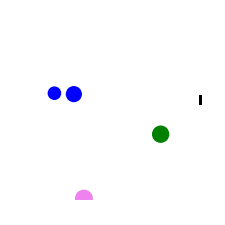

c_full ['blue', 'violet', 'blue', 'green']
prev_c ['blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'green']
c ['green']
prev_c ['blue' 'violet' 'blue' 'green']
c ['violet']
prev_c ['blue' 'violet' 'blue' 'green']
c ['blue']


<IPython.core.display.Javascript object>


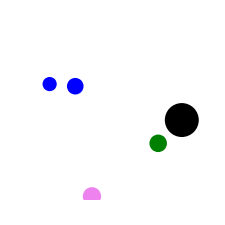

c_full ['blue', 'green', 'violet', 'black', 'blue']
prev_c ['blue' 'green' 'violet' 'black' 'blue']
c ['green']
prev_c ['blue' 'green' 'violet' 'black' 'blue']
c ['blue']
prev_c ['blue' 'green' 'violet' 'black' 'blue']
c ['blue']
prev_c ['blue' 'green' 'violet' 'black' 'blue']
c ['violet']
prev_c ['blue' 'green' 'violet' 'black' 'blue']
c ['black']


<IPython.core.display.Javascript object>


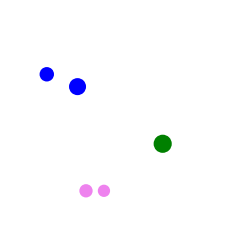

c_full ['green', 'blue', 'blue', 'violet', 'black']
prev_c ['green' 'blue' 'blue' 'violet' 'black']
c ['violet']
prev_c ['green' 'blue' 'blue' 'violet' 'black']
c ['blue']
prev_c ['green' 'blue' 'blue' 'violet' 'black']
c ['green']
prev_c ['green' 'blue' 'blue' 'violet' 'black']
c ['violet']
prev_c ['green' 'blue' 'blue' 'violet' 'black']
c ['blue']


<IPython.core.display.Javascript object>


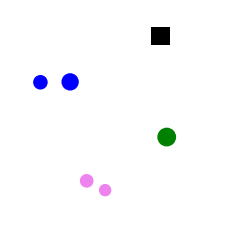

c_full ['violet', 'blue', 'green', 'violet', 'blue']
prev_c ['violet' 'blue' 'green' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'violet' 'blue']
c ['green']
prev_c ['violet' 'blue' 'green' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'violet' 'blue']
c ['violet']


<IPython.core.display.Javascript object>


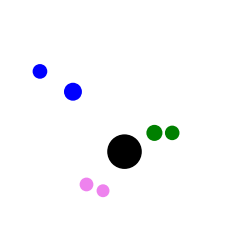

c_full ['blue', 'black', 'violet', 'green', 'blue', 'violet']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['black']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['green']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['green']
prev_c ['blue' 'black' 'violet' 'green' 'blue' 'violet']
c ['blue']


<IPython.core.display.Javascript object>


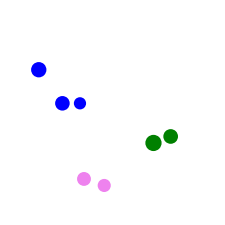

c_full ['violet', 'black', 'blue', 'green', 'violet', 'green', 'blue']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['green']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['violet']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['violet']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['violet' 'black' 'blue' 'green' 'violet' 'green' 'blue']
c ['green']


<IPython.core.display.Javascript object>


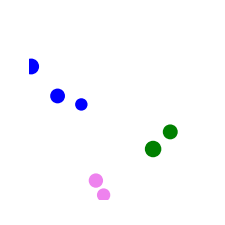

c_full ['green', 'violet', 'violet', 'blue', 'blue', 'blue', 'green']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['violet']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'violet' 'blue' 'blue' 'blue' 'green']
c ['violet']


<IPython.core.display.Javascript object>


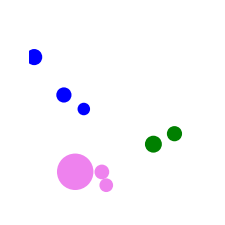

c_full ['green', 'blue', 'blue', 'green', 'violet', 'blue', 'violet']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['green']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['green' 'blue' 'blue' 'green' 'violet' 'blue' 'violet']
c ['green']


<IPython.core.display.Javascript object>


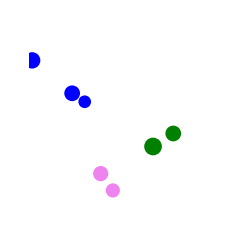

c_full ['violet', 'violet', 'blue', 'blue', 'green', 'blue', 'violet', 'green']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['blue']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['blue']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['violet']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['green']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['violet']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['green']
prev_c ['violet' 'violet' 'blue' 'blue' 'green' 'blue' 'violet' 'green']
c ['blue']


<IPython.core.display.Javascript object>


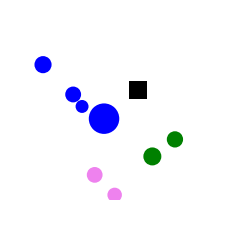

c_full ['blue', 'blue', 'violet', 'green', 'violet', 'green', 'blue']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['green']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'violet' 'green' 'blue']
c ['green']


/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


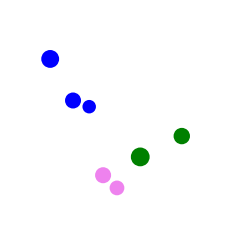

c_full ['black', 'violet', 'blue', 'blue', 'violet', 'green', 'blue', 'blue', 'green']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['blue']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['blue']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['green']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['violet']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['blue']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['violet']
prev_c ['black' 'violet' 'blue' 'blue' 'violet' 'green' 'blue' 'blue' 'green']
c ['green']


<IPython.core.display.Javascript object>


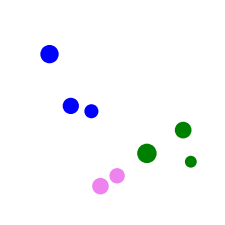

c_full ['blue', 'blue', 'green', 'violet', 'blue', 'violet', 'green']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['violet']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['blue']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['violet']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['green']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['blue']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['green']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['green']
prev_c ['blue' 'blue' 'green' 'violet' 'blue' 'violet' 'green']
c ['blue']


<IPython.core.display.Javascript object>


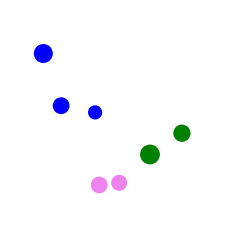

c_full ['violet', 'blue', 'violet', 'green', 'blue', 'green', 'green', 'blue']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['green']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['green']
prev_c ['violet' 'blue' 'violet' 'green' 'blue' 'green' 'green' 'blue']
c ['violet']


<IPython.core.display.Javascript object>


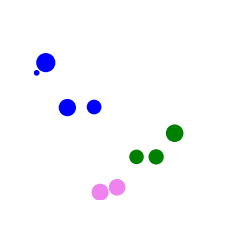

c_full ['blue', 'blue', 'violet', 'green', 'blue', 'green', 'violet']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'green' 'blue' 'green' 'violet']
c ['blue']


<IPython.core.display.Javascript object>


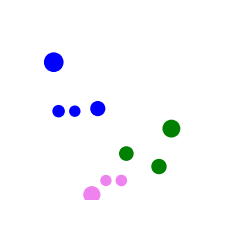

c_full ['violet', 'blue', 'green', 'green', 'blue', 'green', 'blue', 'violet', 'blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['green']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['green']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['green']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'green' 'blue' 'violet' 'blue']
c ['violet']


<IPython.core.display.Javascript object>


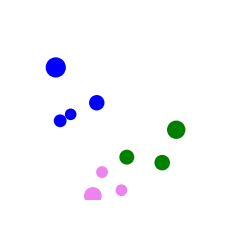

c_full ['violet', 'blue', 'blue', 'green', 'green', 'violet', 'blue', 'blue', 'green', 'violet']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['green']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['blue']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['blue']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['green']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['green']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'green' 'green' 'violet' 'blue' 'blue' 'green'
 'violet']
c ['b

<IPython.core.display.Javascript object>


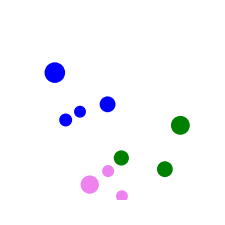

c_full ['green', 'blue', 'violet', 'violet', 'blue', 'green', 'green', 'violet', 'blue', 'blue']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['green']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['blue']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['green']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['blue']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['blue']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'blue' 'green' 'green' 'violet' 'blue'
 'blue']
c ['bl

<IPython.core.display.Javascript object>


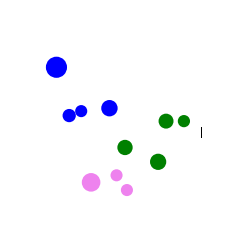

c_full ['green', 'blue', 'violet', 'green', 'blue', 'violet', 'blue', 'violet', 'blue', 'green']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['violet']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet' 'blue'
 'green']
c ['viole

<IPython.core.display.Javascript object>


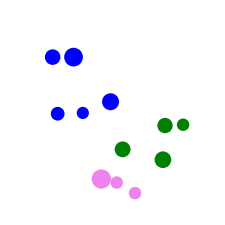

c_full ['green', 'violet', 'blue', 'green', 'blue', 'blue', 'blue', 'green', 'black', 'violet', 'green', 'violet']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['violet']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['violet']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['violet']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['blue']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['green']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['green']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'green' 'black'
 'violet' 'green' 'violet']
c ['blue']
prev_c ['green' 'violet' 'blue' 'green' 'blue' 'blue' 'blue' 'gre

<IPython.core.display.Javascript object>


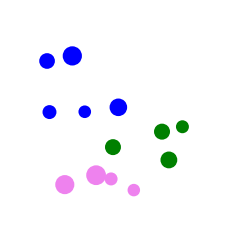

c_full ['violet', 'violet', 'violet', 'blue', 'green', 'green', 'blue', 'green', 'blue', 'blue', 'green', 'blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['green']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['green']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blue'
 'blue' 'green' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'green' 'green' 'blue' 'green' 'blu

<IPython.core.display.Javascript object>


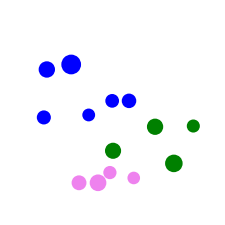

c_full ['violet', 'blue', 'green', 'green', 'blue', 'blue', 'blue', 'violet', 'violet', 'blue', 'violet', 'green', 'green']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['green']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'violet' 'violet'
 'blue' 'violet' 'green' 'green']
c ['green']
prev

<IPython.core.display.Javascript object>


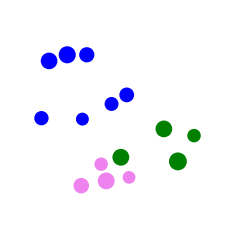

c_full ['blue', 'green', 'blue', 'blue', 'blue', 'violet', 'green', 'blue', 'violet', 'violet', 'blue', 'violet', 'green', 'green']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'violet'
 'violet' 'blue' 'violet' 'green' 'green']
c ['blue']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'violet'
 'violet' 'blue' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'violet'
 'violet' 'blue' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'violet'
 'violet' 'blue' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'violet'
 'violet' 'blue' 'violet' 'green' 'green']
c ['blue']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'violet'
 'violet' 'blue' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'green' 'blue' 'blue' 'blue' 'violet' 'green' 'blue' 'viole

In [42]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        print('ii',ii)
        print(prev_c)
        return prev_c[int(ii-2)],False
    if id1==1:
        return 'black',True
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0],False
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id=id[1:]
tt=tt[1:]
id_f=[2,3,4]


print(c[id_f==1])


    


for t in range(31):
    
        
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf,rec=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        if rec:
            rec1=plt.Rectangle((x_n,y_n), r_n, r_n,fc=c_cf,ec=c_cf) 
            ax.add_patch(rec1)
        else:
            circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
            ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)